In [1]:
import re
import numpy as np
import time
from pathlib import Path
from typing import Optional, Union
from geecs_python_api.controls.interface import GeecsDatabase
from geecs_python_api.controls.devices.geecs_device import GeecsDevice
from datetime import datetime

import png
import os
import yaml
import imageio

import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

import subprocess
import platform
from matplotlib.colors import LinearSegmentedColormap

GeecsDevice.exp_info = GeecsDatabase.collect_exp_info('Undulator')

path config ..\..\..\..\..\..\user data\Configurations.INI
database name  loasis


In [16]:
def EMQ_degauss():

    EMQTrip = GeecsDevice('U_EMQTripletBipolar')
    
    degaussAmp=5
    x=np.linspace(0,16,375)
    y=degaussAmp*np.sin(2*np.pi*x)*np.exp(-x/4)
    
    for i in y:
        EMQTrip.set('Current_Limit.Ch1',i)
        EMQTrip.set('Current_Limit.Ch2',i)
        EMQTrip.set('Current_Limit.Ch3',i)
    
    EMQTrip.close()
    
def chicane_degauss():

    chicane_inner = GeecsDevice('U_ChicaneInner')
    chicane_outer = GeecsDevice('U_ChicaneOuter')
    
    degaussAmp=6
    x=np.linspace(0,12,375)
    y=degaussAmp*np.sin(2*np.pi*x)*np.exp(-x/4)
    for i in y:
        chicane_inner.set('Current',i)
        chicane_outer.set('Current',i)
        
    chicane_inner.close()
    chicane_outer.close()


#Some functions below to establish paths to data, analysis directory. Automatically detects if the computre is on the domain, if it is
#use the given path. Other wise, check hostname and decide path based off of that

def get_domain_windows():
    try:
        # Simplifying command execution, focusing on parsing the domain directly
        result = subprocess.check_output(['systeminfo'], stderr=subprocess.STDOUT, text=True)
        domain_line = next((line for line in result.splitlines() if "Domain" in line), None)
        if domain_line:
            return domain_line.split(':')[1].strip()
    except Exception as e:
        # Logging or handling the exception can be done here if necessary
        return None

def get_base_path():
    # Attempt to retrieve the domain, falling back to hostname if needed
    domain = get_domain_windows()
    hostname = platform.node()

    # Directly mapping conditions to base paths, raising an error if none match
    if domain == 'loasis.gov':
        return 'Z:\\data\\Undulator'
    elif hostname == 'Samuels-MacBook-Pro.local':
        return '/Volumes/vol1/data/Undulator'
    else:
        raise ValueError('Attempting to use an unknown computer. Path to data is unknown.')


def get_current_date():
    month_dict2= {
        "01": "Jan", "02": "Feb", "03": "Mar", "04": "04-Apr",
        "05": "May", "06": "Jun", "07": "07-Jul", "08": "08-Aug",
        "09": "Sep", "10": "Oct", "11": "11-Nov", "12": "12-Dec"
    }

    # Get the current date and time
    current_date_time = datetime.now()

    month = month_dict2[current_date_time.strftime("%m")]
    year = current_date_time.strftime("%Y")
    day = current_date_time.strftime("%d")

    return year, month, day

def create_data_path(year, month, day, scan_number):
    # Mapping of month names to their abbreviated forms with month numbers
    month_dict = {
        "Jan": "01-Jan", "Feb": "02-Feb", "Mar": "03-Mar", "Apr": "04-Apr",
        "May": "05-May", "Jun": "06-Jun", "Jul": "07-Jul", "Aug": "08-Aug",
        "Sep": "09-Sep", "Oct": "10-Oct", "Nov": "11-Nov", "Dec": "12-Dec"
    }

    # Extracting year's last two digits and month number from month_dict
    year_short = str(year)[-2:]
    month_num = month_dict[month][:2]

    # Constructing paths for raw and analysis data
    date_folder = f"{year_short}_{month_num}{str(day).zfill(2)}"  # Ensures day is zero-padded
    base_folder = Path(base_path) / f"Y{year}" / month_dict[month] / date_folder
    raw_data_path = base_folder / "scans" / f"Scan{scan_number:03d}"
    analysis_data_path = base_folder / "analysis" / f"Scan{scan_number:03d}"

    return str(raw_data_path), str(analysis_data_path)

def read_imaq_png_image(file_path: Union[Path, str]) -> np.ndarray:
    """ Read PNG file as output by NI IMAQ, which uses an uncommon format.
    """
    png_reader = png.Reader(file_path.open('rb'))

    # read operations returns rows as a generator. it also adds png headers
    # as attributes to png_reader, including sbit
    width, height, rows, info = png_reader.read()

    # NI IMAQ images use 16 bits per pixel (uncompressed) but often only 
    # the left 12 bits for the data, which is given in the sbit header. 
    # PNG readers don't account for this, so we right shift manually.
    bitdepth = info['bitdepth']
    image = np.array(list(rows), f'uint{bitdepth:d}')

    if png_reader.sbit is None:
        return image
    else:
        significant_bits = ord(png_reader.sbit)
        return np.right_shift(image, bitdepth - significant_bits)

def create_avg_image(scan_dir_base, analysis_dir_base, device, station=None, show_image=False):
    image_dir = Path(scan_dir_base) / device
    all_imgs = []
    
    for path in image_dir.glob('*.png'):  # Assuming images are in PNG format
        img = read_imaq_png_image(path)
        all_imgs.append(img)

    if not all_imgs:  # Early return if no images found
        print("No images found in directory:", image_dir)
        return

    avg_img = np.mean(all_imgs, axis=0)
    avg_img_uint16 = avg_img.astype(np.uint16)
    
    if show_image:
        plt.imshow(avg_img_uint16, cmap=custom_cmap, vmin=0, vmax=np.max(avg_img_uint16))
        plt.colorbar(label="Scale")
        plt.title("2D Array Visualization")
        plt.show()
    
    analysis_dir = Path(analysis_dir_base)
    analysis_dir.mkdir(parents=True, exist_ok=True)  # Simplified directory check and creation
    
    filename = f'{device}{"" if station is None else "_"+station}{"_average"}_16bit.png'
    imageio.imwrite(analysis_dir / filename, avg_img_uint16)
    print(f"Saved image to: {analysis_dir / filename}")

# Helper function for CMYK to RGB conversion
def cmyk_to_rgb(c, m, y, k):
    """Convert CMYK values to RGB."""
    r = 255 * (1.0 - c) * (1.0 - k)
    g = 255 * (1.0 - m) * (1.0 - k)
    b = 255 * (1.0 - y) * (1.0 - k)
    return r / 255.0, g / 255.0, b / 255.0

#Define the custom CMYK colors and convert them to RGB
cmyk_colors = [(0, 0, 0, 0), (0.1, 0.1, 0.1, 0.1), (1, 0.84, 0, 0.15), (0, 0.84, 1, 0), (0, 0, 1, 0)]
rgb_colors = [cmyk_to_rgb(*cmyk) for cmyk in cmyk_colors]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", rgb_colors)


# establish base path to data
try:
    base_path = get_base_path()
except ValueError as e:
    print(f'Error: {e}')

In [17]:
visa_plungers = GeecsDevice('U_VisaPlungers')
velmex = GeecsDevice('U_Velmex')

plunger_var_names = np.flip(["DigitalOutput.Channel 0","DigitalOutput.Channel 1","DigitalOutput.Channel 2","DigitalOutput.Channel 3","DigitalOutput.Channel 4",
"DigitalOutput.Channel 5", "DigitalOutput.Channel 6","DigitalOutput.Channel 7"])

plunger_var_alias = np.flip(["visa8","visa7","visa6","visa5","visa4","visa3","visa2","visa1"])

rad2_positions = [3954,3470,2987,2476.3,1991.2,1498.4,993.3,506.5]



In [18]:
def retract_all_plungers():
    for plunger_name in plunger_var_names:
        visa_plungers.set(plunger_name, 'off')
        time.sleep(0.5)

set plunger:  0
moved velmex to :  3954


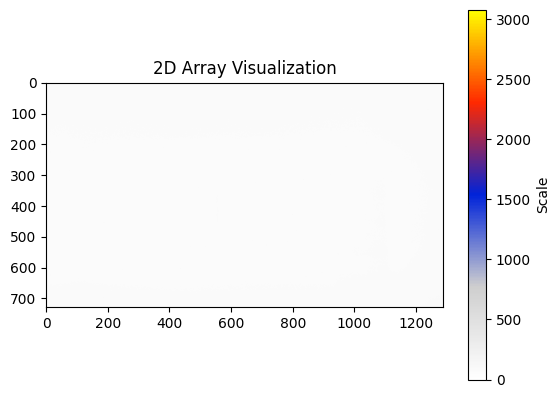

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan012\UC_VisaEBeam1_average_16bit.png


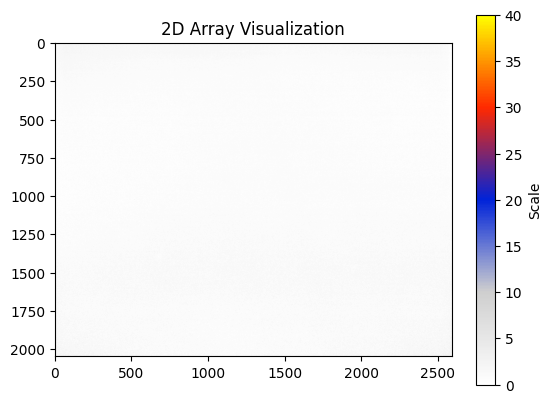

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan012\UC_UndulatorRad2Station1_average_16bit.png
set plunger:  1
moved velmex to :  3470


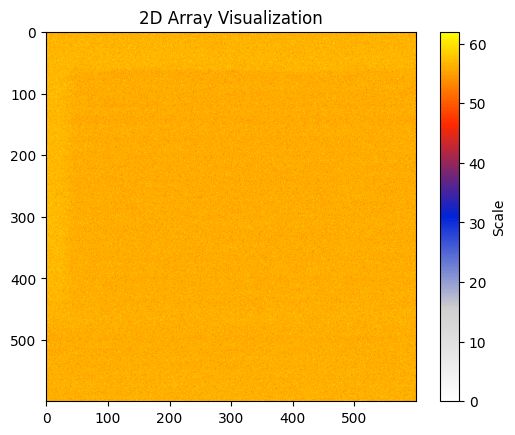

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan013\UC_VisaEBeam2_average_16bit.png


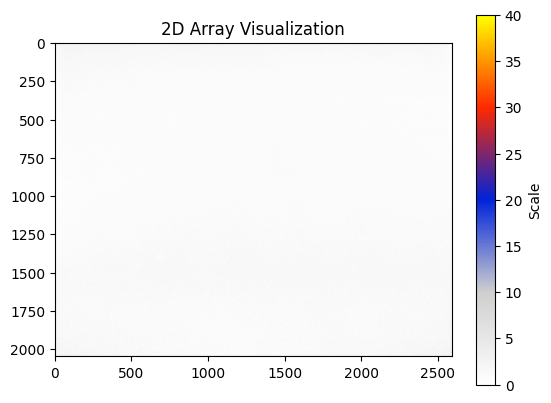

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan013\UC_UndulatorRad2Station2_average_16bit.png
set plunger:  2
moved velmex to :  2987


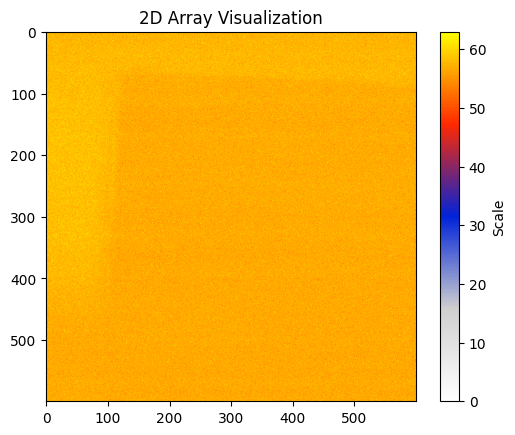

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan014\UC_VisaEBeam3_average_16bit.png


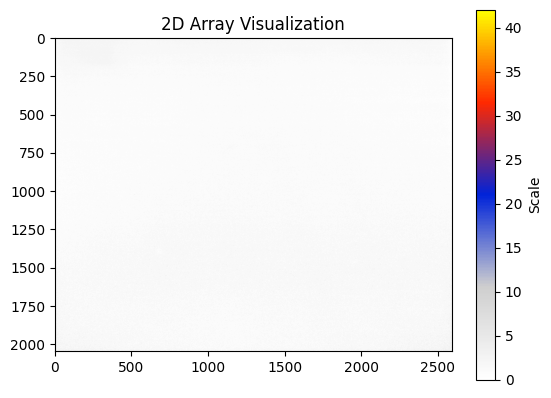

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan014\UC_UndulatorRad2Station3_average_16bit.png
set plunger:  3
moved velmex to :  2476.3


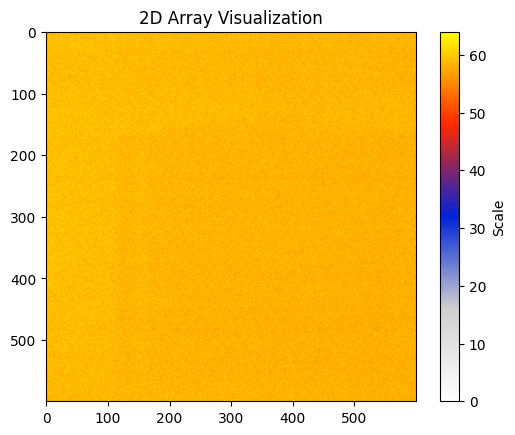

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan015\UC_VisaEBeam4_average_16bit.png


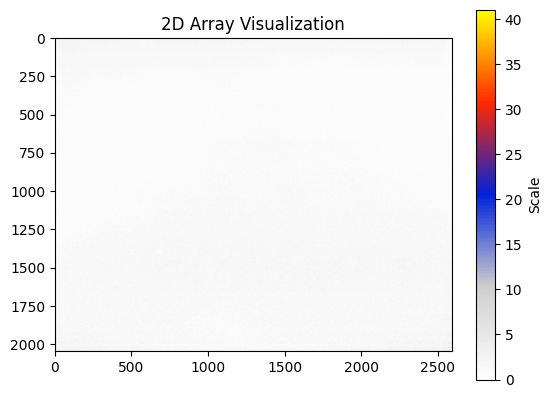

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan015\UC_UndulatorRad2Station4_average_16bit.png
set plunger:  4
moved velmex to :  1991.2


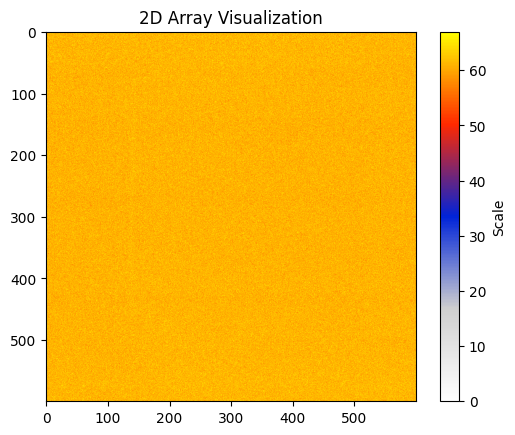

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan016\UC_VisaEBeam5_average_16bit.png


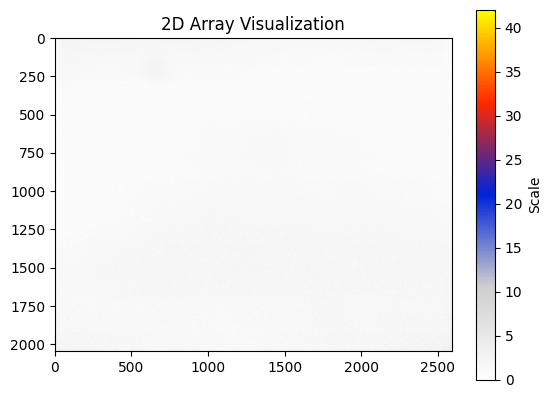

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan016\UC_UndulatorRad2Station5_average_16bit.png
set plunger:  5
moved velmex to :  1498.4


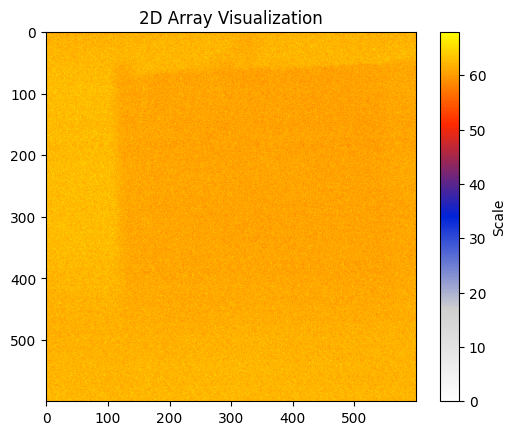

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan017\UC_VisaEBeam6_average_16bit.png


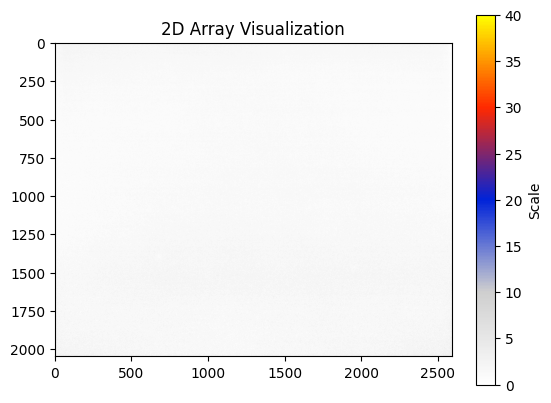

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan017\UC_UndulatorRad2Station6_average_16bit.png
set plunger:  6
moved velmex to :  993.3


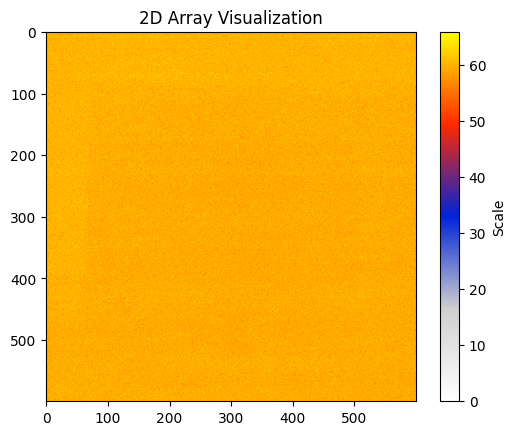

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan018\UC_VisaEBeam7_average_16bit.png


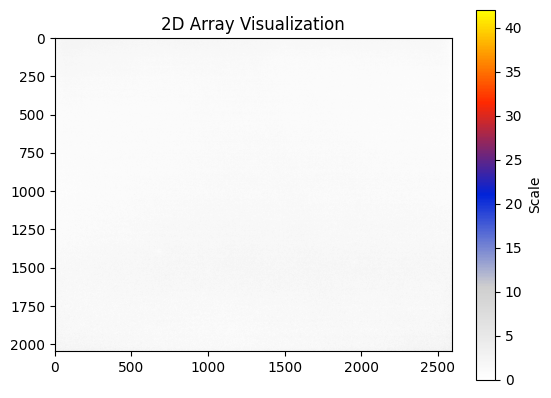

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan018\UC_UndulatorRad2Station7_average_16bit.png
set plunger:  7
moved velmex to :  506.5


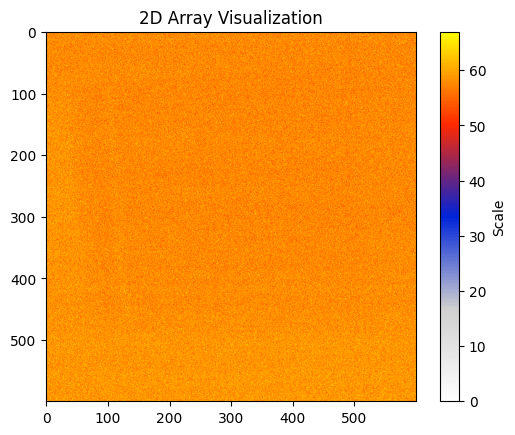

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan019\UC_VisaEBeam8_average_16bit.png


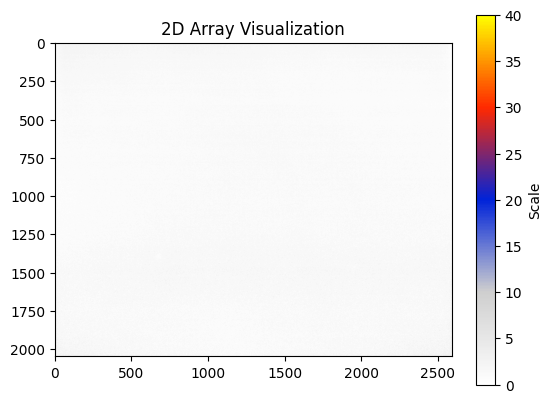

Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0325\analysis\Scan019\UC_UndulatorRad2Station8_average_16bit.png


In [19]:
year, month, day = get_current_date()
scan_numbers = []
for i in range(len(plunger_var_names)):
    retract_all_plungers()
    time.sleep(1)
    visa_plungers.set(plunger_var_names[i],'on')  
    time.sleep(1)
    print('set plunger: ',i)
    velmex.set("Position",rad2_positions[i])
    print('moved velmex to : ',rad2_positions[i])
    time.sleep(2)
    velmex.no_scan(comment="no scan on visa plunger: "+plunger_var_alias[i],shots = 5)
    scan_number = velmex.last_scan_number()
    scan_dir_base, analysis_dir_base = create_data_path(year, month, day, scan_number)

    create_avg_image(scan_dir_base, analysis_dir_base, f'UC_VisaEBeam{i+1}', show_image = True)
    create_avg_image(scan_dir_base, analysis_dir_base, f'UC_UndulatorRad2',station = f'Station{i+1}', show_image = True)

    scan_numbers.append(scan_number)



In [20]:
scan_dir_base, analysis_dir_base = create_data_path(year, month, day, scan_number)
